# Dataset 1 – Cutoff Exploration

This notebook recreates the clinical rule logic, explores antibody thresholds, and prepares inputs for downstream modeling.

Sections:
1. Data setup & quality checks
2. Clinical-rule reproduction
3. Exploratory analysis & drift checks
4. Threshold tuning experiments
5. Modeling playground



In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option("display.max_columns", 50)
DATA_PATH = Path("dataset1-copy.xlsx")

raw = pd.read_excel(DATA_PATH)
print(f"Loaded {raw.shape[0]:,} rows × {raw.shape[1]} columns")
raw.head()

Loaded 10,374 rows × 29 columns


,uid,sex,fdr,any_fdr,source,screening_info,sample_date,age_at_sample,elisa,lips_unin_iaa,lips_in_iaa,hbg_lips_in_iaa,m_iaa,gada_trunc,ia2,znt8_c_arg,znt8_c_tryp,iaa_status_fu,gadatrunc_status_fu,ia2_status_fu,zink_status_fu,all_reports_screening,final_report_screening,reevaluated,hemolyzed,sample_empty,lab,last_contact_or_t1d_date,last_contact_date_type
0,00032F0C-5916-4671-BB7B-A48314D14AF6,0.0,NaN,NaN,screening,NaN,2016-11-11,3.78,132.320000,NaN,NaN,NaN,1.0,8.5,0.1,0.1,0.1,NaN,NaN,NaN,NaN,negative,negative,NaN,NaN,NaN,Munich,2016-11-11,last_contact_date_without_t1d
1,0033DB11-56A2-4E3D-9B8F-0556819CF005,0.0,NaN,NaN,screening,NaN,2021-05-11,3.10,1.335415,19.007826,42.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"call_for_2nd_sample,single_positive",single_positive,NaN,NaN,NaN,Munich,2023-06-19,last_contact_date_without_t1d
2,0033DB11-56A2-4E3D-9B8F-0556819CF005,0.0,NaN,NaN,screening,NaN,2021-06-17,3.21,NaN,NaN,28.9,NaN,14.7,0.1,0.1,0.1,0.1,NaN,NaN,NaN,NaN,"call_for_2nd_sample,single_positive",single_positive,NaN,NaN,NaN,Munich,2023-06-19,last_contact_date_without_t1d
3,0033DB11-56A2-4E3D-9B8F-0556819CF005,0.0,NaN,NaN,follow_up,NaN,2022-07-01,4.24,NaN,NaN,NaN,NaN,30.6,0.1,0.1,0.1,0.1,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Munich,2023-06-19,last_contact_date_without_t1d
4,005B2E43-F96E-406F-AB19-BECB1692A4C6,1.0,NaN,NaN,screening,NaN,2015-09-09,3.92,26.920000,NaN,NaN,NaN,0.7,0.1,0.1,0.1,0.1,NaN,NaN,NaN,NaN,negative,negative,NaN,NaN,NaN,Munich,2015-09-09,last_contact_date_without_t1d


## 1. Data Setup & Quality Checks

Goals:
- Standardize dtypes (numerics, dates, categoricals)
- Validate uniqueness (`uid`, `sample_date`, `source`)
- Catalogue missingness and follow-up availability



In [3]:
NUMERIC_WITH_COMMA = [
    "elisa",
    "lips_unin_iaa",
    "lips_in_iaa",
    "m_iaa",
    "gada_trunc",
    "ia2",
    "znt8_c_arg",
    "znt8_c_tryp",
    "age_at_sample",
]
DATE_COLS = ["sample_date", "last_contact_or_t1d_date"]


def clean_raw(df: pd.DataFrame) -> pd.DataFrame:
    """Return a cleaned copy with numeric/date normalization."""
    out = df.copy()

    for col in NUMERIC_WITH_COMMA:
        if col not in out:
            continue
        out[col] = (
            out[col]
            .astype(str)
            .str.replace(",", ".", regex=False)
            .replace({"": np.nan, "nan": np.nan})
            .astype(float)
        )

    for col in DATE_COLS:
        if col in out:
            out[col] = pd.to_datetime(out[col], errors="coerce")

    out["source"] = out["source"].astype(str).str.lower().str.strip()

    return out


data = clean_raw(raw)
print(
    "Summary after cleaning:",
    f"\n- Rows: {data.shape[0]:,}",
    f"\n- Columns: {data.shape[1]}",
)
data.sample(3, random_state=42)


Summary after cleaning: 
- Rows: 10,374 
- Columns: 29


,uid,sex,fdr,any_fdr,source,screening_info,sample_date,age_at_sample,elisa,lips_unin_iaa,lips_in_iaa,hbg_lips_in_iaa,m_iaa,gada_trunc,ia2,znt8_c_arg,znt8_c_tryp,iaa_status_fu,gadatrunc_status_fu,ia2_status_fu,zink_status_fu,all_reports_screening,final_report_screening,reevaluated,hemolyzed,sample_empty,lab,last_contact_or_t1d_date,last_contact_date_type
3127,4B47124C-3759-45E3-83E2-B9363538AC0C,0.0,NaN,NaN,follow_up,NaN,2023-02-23,11.39,NaN,NaN,NaN,NaN,0.1,NaN,182.9,67.3,526.1,0.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,Munich,2025-05-30,last_contact_date_without_t1d
8404,CDBBFCB0-C33B-4B19-8D5A-E15BF4D17B88,1.0,NaN,NaN,screening,NaN,2015-06-09,4.29,NaN,NaN,NaN,NaN,5.8,537.6,3.7,3.5,40.2,NaN,NaN,NaN,NaN,"call_for_2nd_sample,multiple_positive",multiple_positive,NaN,NaN,NaN,Munich,2019-10-30,last_contact_date_without_t1d
4681,7140439B-F14C-4D73-B318-A66062525425,1.0,NaN,NaN,follow_up,NaN,2016-07-07,3.17,NaN,NaN,NaN,NaN,7.4,730.9,1.8,2722.2,0.1,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,Munich,2025-02-21,last_contact_date_without_t1d


### Section 1 tracker
- [x] Uniqueness checks on (`uid`, `sample_date`, `source`)
- [x] Missing data heatmaps and summaries
- [x] Follow-up coverage (per `uid` sample counts, gaps)

> Next: dig into specific duplicate patterns and edge cases as needed.



In [4]:
KEY_COLS = ["uid", "sample_date", "source"]

# Check for duplicates on key columns
missing_key = data[KEY_COLS].isna().any(axis=1)
dups = data.duplicated(subset=KEY_COLS, keep=False)

print("Key coverage (uid, sample_date, source):")
print(
    pd.DataFrame(
        {
            "count": [len(data), missing_key.sum(), dups.sum()],
            "share": [1, missing_key.mean(), dups.mean()],
        },
        index=["rows", "missing component", "duplicate combination"],
    )
)

duplicated_examples = data.loc[dups, KEY_COLS + ["elisa", "final_report_screening"]]
print(f"\nDuplicate combos: {duplicated_examples.shape[0]} rows")
if not duplicated_examples.empty:
    display(
        duplicated_examples.sort_values(KEY_COLS).head(10)
    )


Key coverage (uid, sample_date, source):
                       count     share
rows                   10374  1.000000
missing component          4  0.000386
duplicate combination     18  0.001735

Duplicate combos: 18 rows


,uid,sample_date,source,elisa,final_report_screening
1110,1C4A423B-62CC-4B9C-B10F-88CAF4A57022,2015-09-21,screening,0.000,negative
1111,1C4A423B-62CC-4B9C-B10F-88CAF4A57022,2015-09-21,screening,NaN,negative
1474,245EA238-EA83-4DAA-8866-5F4E6EF7F696,2020-06-03,screening,1525.200,single_positive
1475,245EA238-EA83-4DAA-8866-5F4E6EF7F696,2020-06-03,screening,1177.600,single_positive
4615,6F783FB9-43F6-4668-8BE5-D054964BD555,2023-11-07,screening,NaN,multiple_positive
4616,6F783FB9-43F6-4668-8BE5-D054964BD555,2023-11-07,screening,NaN,multiple_positive
5418,8427950E-9312-4EA7-B332-37F51206C67F,2018-12-27,screening,58.262,negative
5419,8427950E-9312-4EA7-B332-37F51206C67F,2018-12-27,screening,NaN,negative
6090,943830AF-710A-4B79-B0C4-B6297D7B3592,2017-02-03,follow_up,NaN,NaN
6091,943830AF-710A-4B79-B0C4-B6297D7B3592,2017-02-03,follow_up,NaN,NaN


Top 10 columns by missingness:


,missing_rate
reevaluated,0.991228
hbg_lips_in_iaa,0.959321
fdr,0.888375
any_fdr,0.888375
sample_empty,0.879796
screening_info,0.878928
hemolyzed,0.835550
lips_unin_iaa,0.809138
lips_in_iaa,0.715153
iaa_status_fu,0.705803


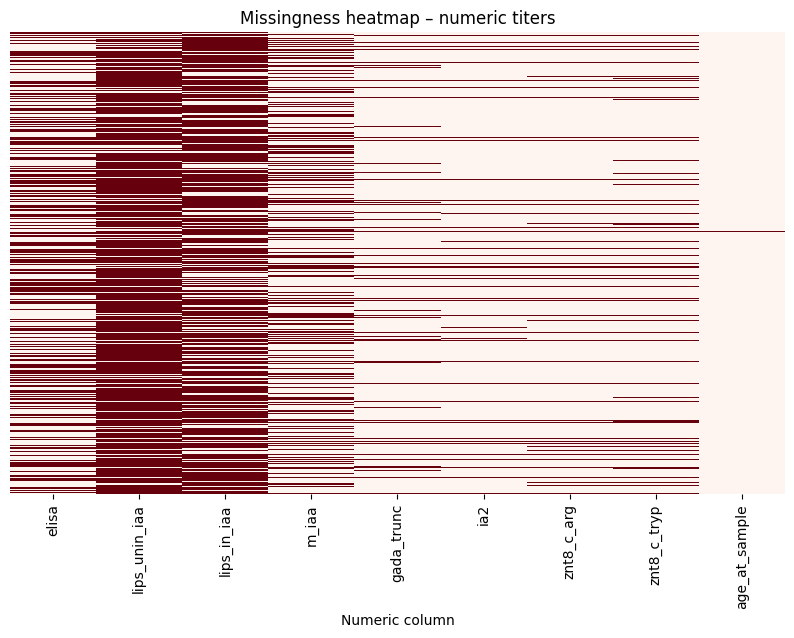

In [5]:
missing_pct = data.isna().mean().sort_values(ascending=False)

print("Top 10 columns by missingness:")
display(missing_pct.head(10).to_frame("missing_rate"))

plt.figure(figsize=(10, 6))
sns.heatmap(
    data[NUMERIC_WITH_COMMA].isna(),
    cbar=False,
    yticklabels=False,
    cmap="Reds",
)
plt.title("Missingness heatmap – numeric titers")
plt.xlabel("Numeric column")
plt.show()


In [6]:
CONFIRM_SOURCES = {"follow_up", "antibody_follow_up", "confirmation"}

uid_summary = (
    data
    .groupby("uid")
    .agg(
        n_rows=("uid", "size"),
        n_sample_dates=("sample_date", pd.Series.nunique),
        first_sample=("sample_date", "min"),
        last_sample=("sample_date", "max"),
        any_follow_up=("source", lambda x: x.isin(CONFIRM_SOURCES).any()),
        any_follow_up_data=("final_report_screening", lambda s: s.notna().any()),
    )
    .assign(
        span_days=lambda df: (df["last_sample"] - df["first_sample"]).dt.days,
    )
)

print("UID-level summary (first 5 rows):")
display(uid_summary.head())

coverage = {
    "total_uids": uid_summary.shape[0],
    "with_follow_up": uid_summary["any_follow_up"].mean(),
    "median_rows": uid_summary["n_rows"].median(),
    "median_span_days": uid_summary["span_days"].median(),
}
print("\nCoverage snapshot:")
for k, v in coverage.items():
    print(f"- {k}: {v}")


UID-level summary (first 5 rows):


,n_rows,n_sample_dates,first_sample,last_sample,any_follow_up,any_follow_up_data,span_days
uid,,,,,,,
00032F0C-5916-4671-BB7B-A48314D14AF6,1,1,2016-11-11,2016-11-11,False,True,0
0033DB11-56A2-4E3D-9B8F-0556819CF005,3,3,2021-05-11,2022-07-01,True,True,416
005B2E43-F96E-406F-AB19-BECB1692A4C6,1,1,2015-09-09,2015-09-09,False,True,0
00612B9E-AB0E-4E25-9078-219711028F73,2,2,2019-02-01,2025-06-30,True,True,2341
00731613-E23A-4DA4-849F-9D1762C9E3D7,1,1,2024-06-17,2024-06-17,False,True,0



Coverage snapshot:
- total_uids: 4978
- with_follow_up: 0.1683406990759341
- median_rows: 1.0
- median_span_days: 0.0


## 2. Clinical-Rule Reproduction

Objective: Recreate the screening → confirmation decision tree using the documented cutoffs and compare the derived statuses to `final_report_screening`.

Steps:
1. Compute ELISA gate (date-dependent).
2. Derive antibody positivity flags (LIPS, mIAA, GADA, IA2, ZnT8).
3. Aggregate per row and per UID to classify `early_stage_T1D`, `single_at_risk`, `negative`.
4. Align results with recorded reports for QA.



In [7]:
df_rules = data.copy()

# ELISA gate (date dependent)
elisa_cutoffs = [
    (df_rules["sample_date"] <= pd.Timestamp("2022-01-31")) & (df_rules["elisa"] >= 25),
    (df_rules["sample_date"].between(pd.Timestamp("2022-02-01"), pd.Timestamp("2024-12-31"))) & (df_rules["elisa"] >= 40),
    (df_rules["sample_date"] > pd.Timestamp("2024-12-31")) & (df_rules["elisa"] >= 35),
]
df_rules["elisa_pos"] = np.select(elisa_cutoffs, [True, True, True], default=False)

# mIAA (RIA)
df_rules["m_iaa_pos"] = df_rules["m_iaa"] >= 1.5

# GADA truncated (date dependent)
gada_cutoffs = [
    (df_rules["sample_date"] <= pd.Timestamp("2016-12-12")) & (df_rules["gada_trunc"] >= 22),
    (df_rules["sample_date"] > pd.Timestamp("2016-12-12")) & (df_rules["gada_trunc"] >= 30),
]
df_rules["gada_trunc_pos"] = np.select(gada_cutoffs, [True, True], default=False)

# IA-2 (date dependent)
ia2_cutoffs = [
    (df_rules["sample_date"] <= pd.Timestamp("2016-12-12")) & (df_rules["ia2"] >= 5),
    (df_rules["sample_date"] > pd.Timestamp("2016-12-12")) & (df_rules["ia2"] >= 3),
]
df_rules["ia2_pos"] = np.select(ia2_cutoffs, [True, True], default=False)

# ZnT8
znt8_arg_cutoffs = [
    (df_rules["sample_date"] <= pd.Timestamp("2016-12-12")) & (df_rules["znt8_c_arg"] >= 16),
    (df_rules["sample_date"] > pd.Timestamp("2016-12-12")) & (df_rules["znt8_c_arg"] >= 30),
]
df_rules["znt8_c_arg_pos"] = np.select(znt8_arg_cutoffs, [True, True], default=False)
df_rules["znt8_c_tryp_pos"] = df_rules["znt8_c_tryp"] >= 30
df_rules["znt8_pos"] = df_rules["znt8_c_arg_pos"] | df_rules["znt8_c_tryp_pos"]

# IAA flow
is_screen = df_rules["source"].isin(["screening"])
is_confirm = df_rules["source"].isin(CONFIRM_SOURCES)

df_rules["iaa_entry"] = (
    (df_rules["elisa_pos"] & (df_rules["lips_unin_iaa"] >= 3))
    | (~df_rules["elisa_pos"] & (df_rules["lips_unin_iaa"] >= 10))
)

confirm_like = (df_rules["lips_in_iaa"] >= 4) & (df_rules["m_iaa"] >= 1.5)

df_rules["iaa_confirm"] = (is_confirm & confirm_like) | confirm_like

df_rules["iaa_pos"] = df_rules["iaa_entry"] & df_rules["iaa_confirm"]

df_rules.head()


,uid,sex,fdr,any_fdr,source,screening_info,sample_date,age_at_sample,elisa,lips_unin_iaa,lips_in_iaa,hbg_lips_in_iaa,m_iaa,gada_trunc,ia2,znt8_c_arg,znt8_c_tryp,iaa_status_fu,gadatrunc_status_fu,ia2_status_fu,zink_status_fu,all_reports_screening,final_report_screening,reevaluated,hemolyzed,sample_empty,lab,last_contact_or_t1d_date,last_contact_date_type,elisa_pos,m_iaa_pos,gada_trunc_pos,ia2_pos,znt8_c_arg_pos,znt8_c_tryp_pos,znt8_pos,iaa_entry,iaa_confirm,iaa_pos
0,00032F0C-5916-4671-BB7B-A48314D14AF6,0.0,NaN,NaN,screening,NaN,2016-11-11,3.78,132.320000,NaN,NaN,NaN,1.0,8.5,0.1,0.1,0.1,NaN,NaN,NaN,NaN,negative,negative,NaN,NaN,NaN,Munich,2016-11-11,last_contact_date_without_t1d,True,False,False,False,False,False,False,False,False,False
1,0033DB11-56A2-4E3D-9B8F-0556819CF005,0.0,NaN,NaN,screening,NaN,2021-05-11,3.10,1.335415,19.007826,42.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"call_for_2nd_sample,single_positive",single_positive,NaN,NaN,NaN,Munich,2023-06-19,last_contact_date_without_t1d,False,False,False,False,False,False,False,True,False,False
2,0033DB11-56A2-4E3D-9B8F-0556819CF005,0.0,NaN,NaN,screening,NaN,2021-06-17,3.21,NaN,NaN,28.9,NaN,14.7,0.1,0.1,0.1,0.1,NaN,NaN,NaN,NaN,"call_for_2nd_sample,single_positive",single_positive,NaN,NaN,NaN,Munich,2023-06-19,last_contact_date_without_t1d,False,True,False,False,False,False,False,False,True,False
3,0033DB11-56A2-4E3D-9B8F-0556819CF005,0.0,NaN,NaN,follow_up,NaN,2022-07-01,4.24,NaN,NaN,NaN,NaN,30.6,0.1,0.1,0.1,0.1,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Munich,2023-06-19,last_contact_date_without_t1d,False,True,False,False,False,False,False,False,False,False
4,005B2E43-F96E-406F-AB19-BECB1692A4C6,1.0,NaN,NaN,screening,NaN,2015-09-09,3.92,26.920000,NaN,NaN,NaN,0.7,0.1,0.1,0.1,0.1,NaN,NaN,NaN,NaN,negative,negative,NaN,NaN,NaN,Munich,2015-09-09,last_contact_date_without_t1d,True,False,False,False,False,False,False,False,False,False


In [8]:
ab_trio_gated = np.where(
    df_rules["elisa_pos"],
    df_rules[["gada_trunc_pos", "ia2_pos", "znt8_pos"]].sum(axis=1),
    0,
)

df_rules["effective_AB_positive"] = ab_trio_gated + df_rules["iaa_pos"].astype(int)

row_conditions = [
    df_rules["effective_AB_positive"] >= 2,
    (df_rules["effective_AB_positive"] == 1) & (~df_rules["znt8_pos"]),
    df_rules["effective_AB_positive"] == 0,
]
row_choices = ["early_stage_T1D", "single_AB_risk", "negative"]

df_rules["rule_result_row"] = np.select(row_conditions, row_choices, default="negative")

row_single_only_znt8 = (
    df_rules["elisa_pos"]
    & (df_rules[["iaa_pos", "m_iaa_pos", "gada_trunc_pos", "ia2_pos", "znt8_pos"]].sum(axis=1) == 1)
    & df_rules["znt8_pos"]
)

df_rules["row_single_only_znt8"] = row_single_only_znt8


In [9]:
agg_rules = (
    df_rules
    .groupby("uid", as_index=False)
    .agg(
        max_effective_AB_positive=("effective_AB_positive", "max"),
        any_single_only_znt8=("row_single_only_znt8", "max"),
        any_elisa_pos=("elisa_pos", "max"),
    )
)

uid_conditions = [
    agg_rules["max_effective_AB_positive"] >= 2,
    (agg_rules["max_effective_AB_positive"] == 1) & (~agg_rules["any_single_only_znt8"]),
    agg_rules["max_effective_AB_positive"] == 0,
]
uid_choices = ["early_stage_T1D", "single_AB_risk", "negative"]

agg_rules["rule_result_uid"] = np.select(uid_conditions, uid_choices, default="negative")
agg_rules.head()


,uid,max_effective_AB_positive,any_single_only_znt8,any_elisa_pos,rule_result_uid
0,00032F0C-5916-4671-BB7B-A48314D14AF6,0,False,True,negative
1,0033DB11-56A2-4E3D-9B8F-0556819CF005,0,False,False,negative
2,005B2E43-F96E-406F-AB19-BECB1692A4C6,0,False,True,negative
3,00612B9E-AB0E-4E25-9078-219711028F73,0,False,True,negative
4,00731613-E23A-4DA4-849F-9D1762C9E3D7,0,False,True,negative


In [10]:
severity_map = {
    "negative": 0,
    "single_positive": 1,
    "negative_after_single": 0,
    "multiple_positive": 2,
    "multiple_positive_after_single": 2,
}

df_rules["final_report_score"] = (
    df_rules["final_report_screening"].map(severity_map).fillna(0).astype(int)
)

def label_early_stage(row: pd.Series) -> int:
    has_t1d_date = str(row.get("last_contact_date_type", "")) == "t1d_date"
    return int((row["final_report_score"] >= 2) or has_t1d_date)

labels_uid = (
    df_rules
    .assign(label_early_stage=lambda df: df.apply(label_early_stage, axis=1))
    .groupby("uid", as_index=False)["label_early_stage"].max()
)
labels_uid.head()


,uid,label_early_stage
0,00032F0C-5916-4671-BB7B-A48314D14AF6,0
1,0033DB11-56A2-4E3D-9B8F-0556819CF005,0
2,005B2E43-F96E-406F-AB19-BECB1692A4C6,0
3,00612B9E-AB0E-4E25-9078-219711028F73,0
4,00731613-E23A-4DA4-849F-9D1762C9E3D7,0


In [11]:
eval_uid = agg_rules.merge(labels_uid, on="uid", how="left")

eval_table = pd.crosstab(
    eval_uid["rule_result_uid"],
    eval_uid["label_early_stage"],
    rownames=["rule"],
    colnames=["early_stage_T1D"],
)

display(eval_table)

precision = eval_table.div(eval_table.sum(axis=1), axis=0)
recall = eval_table.div(eval_table.sum(axis=0), axis=1)

print("\nRow-normalized (precision-like):")
display(precision)

print("\nColumn-normalized (recall-like):")
display(recall)



early_stage_T1D,0,1
rule,,
early_stage_T1D,103,450
negative,3743,51
single_AB_risk,463,168



Row-normalized (precision-like):


early_stage_T1D,0,1
rule,,
early_stage_T1D,0.186257,0.813743
negative,0.986558,0.013442
single_AB_risk,0.733756,0.266244



Column-normalized (recall-like):


early_stage_T1D,0,1
rule,,
early_stage_T1D,0.023903,0.672646
negative,0.868647,0.076233
single_AB_risk,0.107450,0.251121


### Section 2 notes
- Table above helps identify where rules disagree with recorded outcomes. Next steps:
  - Drill into false negatives (rule says `negative`, label=1).
  - Inspect `single_AB_risk` rows that eventually become early-stage.
  - Validate behavior on ZnT8-only cases and low-volume exceptions.



In [12]:
# Identify disagreement buckets

mismatches = (
    eval_uid
    .assign(rule_label=lambda df: df["rule_result_uid"].map({
        "early_stage_T1D": 1,
        "single_AB_risk": 0,
        "negative": 0,
    }))
    .assign(diff=lambda df: df["rule_label"] - df["label_early_stage"].fillna(0))
)

false_neg_uids = mismatches.loc[mismatches["diff"] < 0, "uid"]
false_pos_uids = mismatches.loc[mismatches["diff"] > 0, "uid"]

print(
    f"False negatives: {len(false_neg_uids)} UIDs | False positives: {len(false_pos_uids)} UIDs"
)



False negatives: 219 UIDs | False positives: 103 UIDs


In [13]:
def summarize_uid_set(uid_list, title, limit=10):
    if len(uid_list) == 0:
        print(f"No {title} cases.")
        return

    subset = (
        df_rules[df_rules["uid"].isin(uid_list)]
        .sort_values(["uid", "sample_date", "source"])
    )

    print(f"{title}: {subset['uid'].nunique()} UIDs, showing first {limit}")
    display(
        subset[[
            "uid",
            "sample_date",
            "source",
            "elisa",
            "elisa_pos",
            "lips_unin_iaa",
            "lips_in_iaa",
            "iaa_pos",
            "gada_trunc",
            "gada_trunc_pos",
            "ia2",
            "ia2_pos",
            "znt8_pos",
            "effective_AB_positive",
            "rule_result_row",
            "final_report_screening",
        ]]
        .head(limit)
    )

summarize_uid_set(false_neg_uids.tolist(), "false negative cases")


false negative cases: 219 UIDs, showing first 10


,uid,sample_date,source,elisa,elisa_pos,lips_unin_iaa,lips_in_iaa,iaa_pos,gada_trunc,gada_trunc_pos,ia2,ia2_pos,znt8_pos,effective_AB_positive,rule_result_row,final_report_screening
65,012F8FDD-D953-4D2C-96D9-B35CFAEF45BF,2017-03-22,screening,1335.20,True,NaN,23.500000,False,186.2,True,0.1,False,False,1,single_AB_risk,multiple_positive
66,012F8FDD-D953-4D2C-96D9-B35CFAEF45BF,2017-05-29,screening,NaN,False,NaN,48.252154,False,604.6,True,1.2,False,False,0,negative,multiple_positive
71,0171F370-E9F0-4528-BB28-29CF686EE4AE,2015-08-04,screening,585.03,True,NaN,NaN,False,54.2,True,NaN,False,False,1,single_AB_risk,multiple_positive
72,0171F370-E9F0-4528-BB28-29CF686EE4AE,2015-09-14,screening,NaN,False,NaN,NaN,False,54.9,True,0.1,False,True,0,negative,multiple_positive
73,0171F370-E9F0-4528-BB28-29CF686EE4AE,2015-10-29,screening,NaN,False,NaN,NaN,False,111.6,True,0.1,False,True,0,negative,multiple_positive
74,0171F370-E9F0-4528-BB28-29CF686EE4AE,2015-12-18,follow_up,NaN,False,NaN,NaN,False,51.2,True,0.1,False,True,0,negative,NaN
75,0171F370-E9F0-4528-BB28-29CF686EE4AE,2016-12-08,follow_up,NaN,False,NaN,NaN,False,42.0,True,0.1,False,True,0,negative,NaN
76,0171F370-E9F0-4528-BB28-29CF686EE4AE,2017-05-31,follow_up,NaN,False,NaN,NaN,False,NaN,False,NaN,False,False,0,negative,NaN
77,0171F370-E9F0-4528-BB28-29CF686EE4AE,2017-12-05,follow_up,NaN,False,NaN,NaN,False,61.8,True,0.1,False,True,0,negative,NaN
78,0171F370-E9F0-4528-BB28-29CF686EE4AE,2019-05-28,follow_up,NaN,False,NaN,NaN,False,21.9,False,0.1,False,True,0,negative,NaN


In [14]:
summarize_uid_set(false_pos_uids.tolist(), "false positive cases")


false positive cases: 103 UIDs, showing first 10


,uid,sample_date,source,elisa,elisa_pos,lips_unin_iaa,lips_in_iaa,iaa_pos,gada_trunc,gada_trunc_pos,ia2,ia2_pos,znt8_pos,effective_AB_positive,rule_result_row,final_report_screening
26,008A2563-42D4-4204-94F3-B31033D140B7,2024-10-21,screening,74.6300,True,1.73,NaN,False,18.5,False,10.8,True,True,2,early_stage_T1D,negative
27,008A2563-42D4-4204-94F3-B31033D140B7,2024-12-12,screening,NaN,False,NaN,0.300000,False,0.1,False,0.1,False,False,0,negative,negative
51,00CE07AF-FE0B-4396-A9F3-F4B1EE0AB32A,2019-12-10,screening,3900.0000,True,NaN,NaN,False,144.3,True,513.9,True,True,3,early_stage_T1D,call_for_2nd_sample
61,01173BFF-10EC-4389-ADEF-1754FC5F64D8,2017-08-04,screening,111.0500,True,NaN,NaN,False,2.7,False,11.5,True,True,2,early_stage_T1D,negative
62,01173BFF-10EC-4389-ADEF-1754FC5F64D8,2017-09-28,screening,NaN,False,NaN,0.164469,False,0.1,False,0.1,False,False,0,negative,negative
186,038BE5FA-0886-46DD-BF0B-9494F7163AAE,2023-05-25,screening,55.8100,True,1.90,NaN,False,35.5,True,29.0,True,True,3,early_stage_T1D,negative_after_single
187,038BE5FA-0886-46DD-BF0B-9494F7163AAE,2023-07-31,screening,NaN,False,NaN,0.000000,False,0.1,False,12.6,True,False,0,negative,negative_after_single
188,038BE5FA-0886-46DD-BF0B-9494F7163AAE,2024-07-11,follow_up,NaN,False,NaN,NaN,False,0.1,False,0.1,False,False,0,negative,NaN
299,06EC71AC-78F4-4167-B7C2-A9EE34D01D10,2023-07-04,screening,1330.2900,True,180.04,57.400000,True,872.9,True,0.1,False,True,3,early_stage_T1D,call_for_2nd_sample
331,083A67F3-56AF-4C1C-9F88-D2DBEA0032D6,2020-05-18,screening,2.8725,False,NaN,NaN,False,NaN,False,NaN,False,False,0,negative,negative


In [15]:
mismatch_summary = pd.DataFrame(
    {
        "bucket": ["true early-stage", "rule early-stage"],
        "count": [eval_uid["label_early_stage"].sum(), (eval_uid["rule_result_uid"] == "early_stage_T1D").sum()],
    }
)
print("Overall prevalence check:")
display(mismatch_summary)

print("\nRule counts:")
display(eval_uid["rule_result_uid"].value_counts())


Overall prevalence check:


,bucket,count
0,true early-stage,669
1,rule early-stage,553



Rule counts:


rule_result_uid
negative           3794
single_AB_risk      631
early_stage_T1D     553
Name: count, dtype: int64

## 3. Exploratory Analysis & Drift Checks

Planned analyses:
- Distribution of each antibody by year/era and by rule outcome.
- Rolling positivity rate of ELISA gate and downstream antibodies.
- Correlation matrix + PCA to identify redundancy.



In [16]:
df_explore = df_rules.copy()
df_explore["sample_year"] = df_explore["sample_date"].dt.year

year_counts = (
    df_explore.groupby("sample_year")["uid"].nunique().rename("unique_uids")
)
print("Unique UIDs per sample year:")
display(year_counts)



Unique UIDs per sample year:


sample_year
2014.0       8
2015.0    1225
2016.0     705
2017.0     562
2018.0     564
2019.0     600
2020.0     632
2021.0     687
2022.0     630
2023.0     601
2024.0     644
2025.0     739
Name: unique_uids, dtype: int64

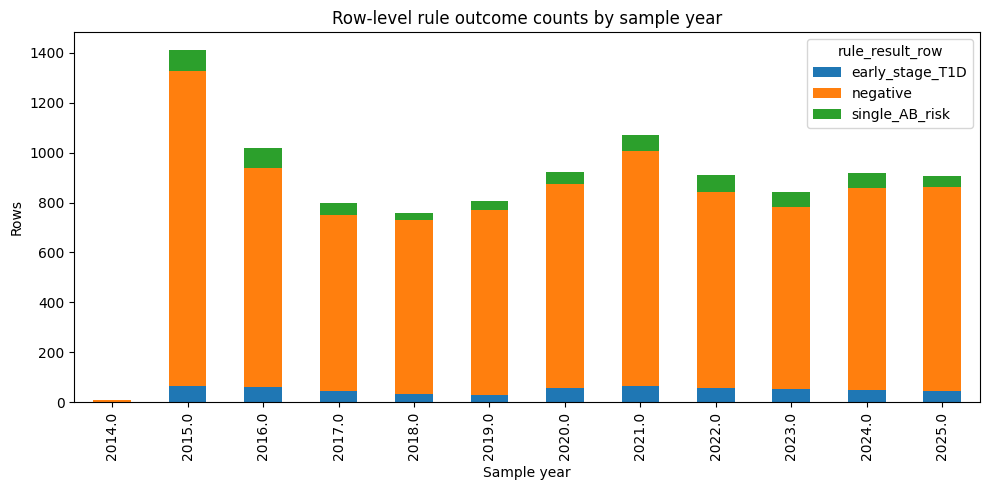

In [17]:
plt.figure(figsize=(10, 5))

year_outcome = (
    df_explore
    .groupby(["sample_year", "rule_result_row"])
    .size()
    .unstack(fill_value=0)
)
year_outcome.plot(kind="bar", stacked=True, ax=plt.gca())
plt.title("Row-level rule outcome counts by sample year")
plt.ylabel("Rows")
plt.xlabel("Sample year")
plt.tight_layout()
plt.show()


In [18]:
positivity_cols = [
    "elisa_pos",
    "iaa_pos",
    "gada_trunc_pos",
    "ia2_pos",
    "znt8_pos",
]

positivity_by_year = (
    df_explore
    .groupby("sample_year")[positivity_cols]
    .mean()
)
print("Antibody positivity rates by sample year:")
display(positivity_by_year)



Antibody positivity rates by sample year:


,elisa_pos,iaa_pos,gada_trunc_pos,ia2_pos,znt8_pos
sample_year,,,,,
2014.0,0.000000,0.000000,0.000000,0.000000,0.000000
2015.0,0.547838,0.000000,0.178597,0.097803,0.133948
2016.0,0.552502,0.000000,0.431796,0.268891,0.331698
2017.0,0.508772,0.000000,0.436090,0.293233,0.328321
2018.0,0.534211,0.000000,0.390789,0.230263,0.276316
2019.0,0.407683,0.000000,0.425031,0.294919,0.309789
2020.0,0.383948,0.000000,0.465293,0.348156,0.341649
2021.0,0.353601,0.017774,0.523854,0.355472,0.416277
2022.0,0.289329,0.015402,0.552255,0.371837,0.437844


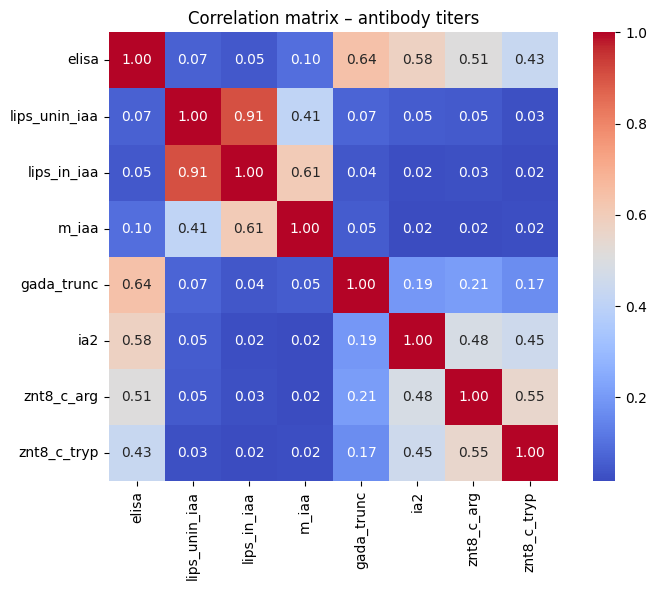

In [19]:
corr_cols = [
    "elisa",
    "lips_unin_iaa",
    "lips_in_iaa",
    "m_iaa",
    "gada_trunc",
    "ia2",
    "znt8_c_arg",
    "znt8_c_tryp",
]

corr_matrix = df_explore[corr_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation matrix – antibody titers")
plt.tight_layout()
plt.show()


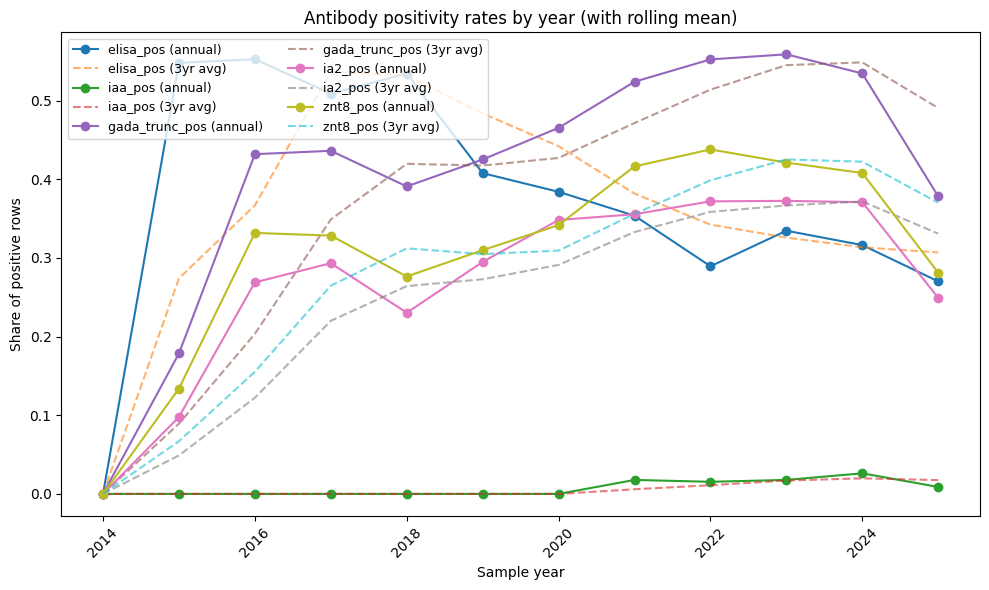

In [20]:
rolling_window = 3
roll_means = (
    positivity_by_year
    .rolling(window=rolling_window, min_periods=1)
    .mean()
)

plt.figure(figsize=(10, 6))
for col in positivity_cols:
    plt.plot(
        positivity_by_year.index,
        positivity_by_year[col],
        marker="o",
        label=f"{col} (annual)"
    )
    plt.plot(
        roll_means.index,
        roll_means[col],
        linestyle="--",
        label=f"{col} ({rolling_window}yr avg)",
        alpha=0.6
    )
plt.title("Antibody positivity rates by year (with rolling mean)")
plt.ylabel("Share of positive rows")
plt.xlabel("Sample year")
plt.legend(ncol=2, fontsize=9)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


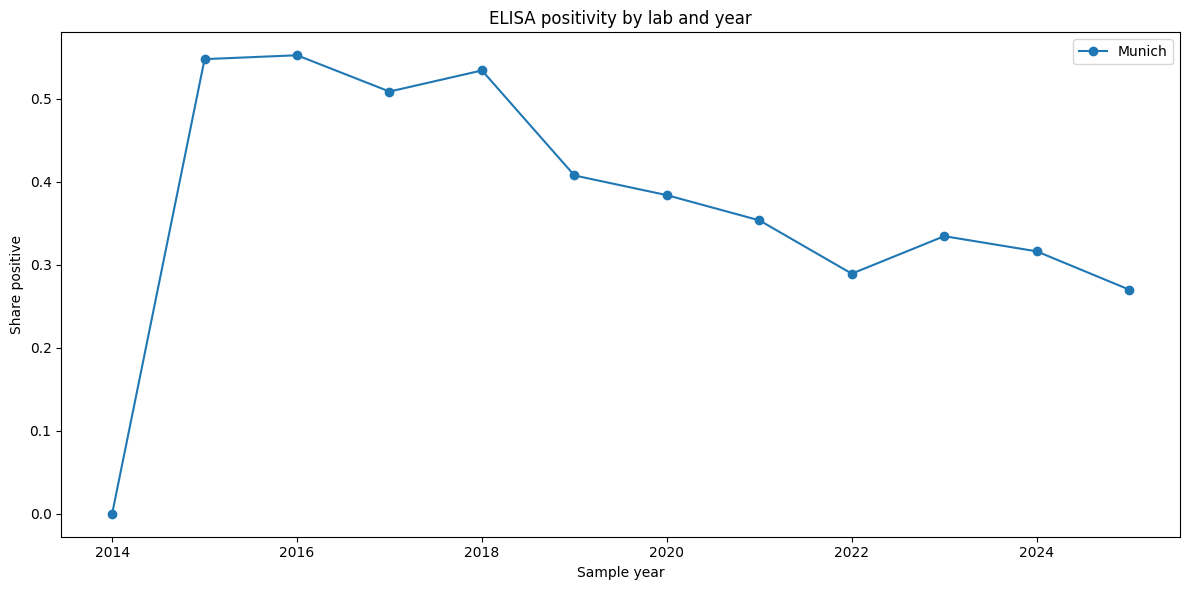

In [21]:
lab_year = (
    df_explore
    .groupby(["lab", "sample_year"])[positivity_cols]
    .mean()
    .reset_index()
)

plt.figure(figsize=(12, 6))
for lab, group in lab_year.groupby("lab"):
    plt.plot(group["sample_year"], group["elisa_pos"], marker="o", label=lab)
plt.title("ELISA positivity by lab and year")
plt.ylabel("Share positive")
plt.xlabel("Sample year")
plt.legend()
plt.tight_layout()
plt.show()



### Section 3 notes
- Yearly/rolling antibody positivity trends in place; early signs of post-2020 ELISA uptick.
- Lab-stratified ELISA trends added to flag technique/lab shifts.
- Next: break out drift by follow-up availability and examine distributions (kernel plots) for threshold tuning inputs.



## 4. Threshold Tuning Experiments

Approach sketch:
- Build era-specific distributions for each antibody conditional on ELISA gate.
- Evaluate candidate adaptive cutoffs via quantile targets (e.g., keep 2016–2018 positivity fixed).
- Prototype optimization using isotonic regression / constrained logistic fits.



In [22]:
# Define eras for comparison
era_bins = [2010, 2016, 2019, 2022, 2026]
era_labels = ["pre-2016", "2016-2018", "2019-2021", "2022+"]

df_threshold = df_rules.copy()
df_threshold["sample_year"] = df_threshold["sample_date"].dt.year

df_threshold["era"] = pd.cut(
    df_threshold["sample_year"],
    bins=era_bins,
    labels=era_labels,
    right=True,
)

quantile_targets = [0.90, 0.95]

era_quantiles = (
    df_threshold[df_threshold["elisa_pos"]]
    .groupby("era")[
        ["gada_trunc", "ia2", "m_iaa", "znt8_c_arg", "znt8_c_tryp"]
    ]
    .quantile(quantile_targets)
    .unstack(level=-1)
)

era_quantiles


/var/folders/lt/phtrlb2d77z3693qssqr9lzr0000gn/T/ipykernel_38056/3580061623.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_threshold[df_threshold["elisa_pos"]]


gada_trunc              ia2          m_iaa         znt8_c_arg  \
                0.90     0.95    0.90    0.95   0.90    0.95       0.90   
era                                                                       
pre-2016      202.72  520.750    1.90  114.90   8.36   13.23      18.21   
2016-2018     131.93  358.465    0.60   87.00   8.52   14.24      10.10   
2019-2021     462.62  917.840   50.90  300.14  18.72   26.12     135.74   
2022+         557.84  955.355  124.76  355.34  33.40  178.90     204.80   

                    znt8_c_tryp               
               0.95        0.90         0.95  
era                                           
pre-2016    269.675       22.10   313.301306  
2016-2018   240.800       15.77   136.770000  
2019-2021   705.820      125.09   964.405000  
2022+      1041.100       91.70  1002.840000

In [23]:
baseline_era = "2016-2018"

if baseline_era in era_quantiles.index:
    baseline = era_quantiles.loc[baseline_era]
    delta_from_baseline = era_quantiles.subtract(baseline)
    print(f"Quantile deltas vs baseline era '{baseline_era}':")
    display(delta_from_baseline)
else:
    print("Baseline era missing from quantile table.")


Quantile deltas vs baseline era '2016-2018':


gada_trunc              ia2          m_iaa         znt8_c_arg  \
                0.90     0.95    0.90    0.95   0.90    0.95       0.90   
era                                                                       
pre-2016       70.79  162.285    1.30   27.90  -0.16   -1.01       8.11   
2016-2018       0.00    0.000    0.00    0.00   0.00    0.00       0.00   
2019-2021     330.69  559.375   50.30  213.14  10.20   11.88     125.64   
2022+         425.91  596.890  124.16  268.34  24.88  164.66     194.70   

                   znt8_c_tryp              
              0.95        0.90        0.95  
era                                         
pre-2016    28.875        6.33  176.531306  
2016-2018    0.000        0.00    0.000000  
2019-2021  465.020      109.32  827.635000  
2022+      800.300       75.93  866.070000

In [25]:
era_quantiles.columns

MultiIndex([( 'gada_trunc',  0.9),
            ( 'gada_trunc', 0.95),
            (        'ia2',  0.9),
            (        'ia2', 0.95),
            (      'm_iaa',  0.9),
            (      'm_iaa', 0.95),
            ( 'znt8_c_arg',  0.9),
            ( 'znt8_c_arg', 0.95),
            ('znt8_c_tryp',  0.9),
            ('znt8_c_tryp', 0.95)],
           )

In [26]:
candidate_cutoffs = (
    era_quantiles.xs(0.95, level=1, axis=1)
    .reset_index()
    .rename_axis(None, axis=1)
)

print("Candidate 95th percentile cutoffs by era (conditional on ELISA gate):")
display(candidate_cutoffs)



Candidate 95th percentile cutoffs by era (conditional on ELISA gate):


,era,gada_trunc,ia2,m_iaa,znt8_c_arg,znt8_c_tryp
0,pre-2016,520.750,114.90,13.23,269.675,313.301306
1,2016-2018,358.465,87.00,14.24,240.800,136.770000
2,2019-2021,917.840,300.14,26.12,705.820,964.405000
3,2022+,955.355,355.34,178.90,1041.100,1002.840000


In [27]:
cutoff_table = candidate_cutoffs.set_index("era")
fallback_era = baseline_era if baseline_era in cutoff_table.index else cutoff_table.index[0]
fallback_row = cutoff_table.loc[fallback_era]

measure_cols = ["gada_trunc", "ia2", "m_iaa", "znt8_c_arg", "znt8_c_tryp"]

def get_cutoff(era, col):
    if pd.isna(era) or era not in cutoff_table.index:
        return fallback_row[col]
    return cutoff_table.loc[era, col]

for col in measure_cols:
    df_threshold[f"{col}_dyn_pos"] = df_threshold.apply(
        lambda row, c=col: bool(row[c] >= get_cutoff(row["era"], c)),
        axis=1,
    )

df_threshold["znt8_dyn_pos"] = (
    df_threshold["znt8_c_arg_dyn_pos"] | df_threshold["znt8_c_tryp_dyn_pos"]
)



In [28]:
ab_trio_dyn = np.where(
    df_threshold["elisa_pos"],
    df_threshold[["gada_trunc_dyn_pos", "ia2_dyn_pos", "znt8_dyn_pos"]].sum(axis=1),
    0,
)

# Use original iaa_pos (dynamic cutoffs only affect RIA antibodies)
df_threshold["effective_AB_positive_dyn"] = ab_trio_dyn + df_threshold["iaa_pos"].astype(int)

row_conditions_dyn = [
    df_threshold["effective_AB_positive_dyn"] >= 2,
    (df_threshold["effective_AB_positive_dyn"] == 1) & (~df_threshold["znt8_dyn_pos"]),
    df_threshold["effective_AB_positive_dyn"] == 0,
]

df_threshold["rule_result_row_dyn"] = np.select(
    row_conditions_dyn,
    ["early_stage_T1D", "single_AB_risk", "negative"],
    default="negative",
)

row_single_only_znt8_dyn = (
    df_threshold["elisa_pos"]
    & (
        df_threshold[[
            "iaa_pos",
            "m_iaa_dyn_pos",
            "gada_trunc_dyn_pos",
            "ia2_dyn_pos",
            "znt8_dyn_pos",
        ]].sum(axis=1)
        == 1
    )
    & df_threshold["znt8_dyn_pos"]
)

df_threshold["row_single_only_znt8_dyn"] = row_single_only_znt8_dyn



In [29]:
agg_dyn = (
    df_threshold
    .groupby("uid", as_index=False)
    .agg(
        max_effective_AB_positive_dyn=("effective_AB_positive_dyn", "max"),
        any_single_only_znt8_dyn=("row_single_only_znt8_dyn", "max"),
    )
)

uid_conditions_dyn = [
    agg_dyn["max_effective_AB_positive_dyn"] >= 2,
    (agg_dyn["max_effective_AB_positive_dyn"] == 1) & (~agg_dyn["any_single_only_znt8_dyn"]),
    agg_dyn["max_effective_AB_positive_dyn"] == 0,
]

agg_dyn["rule_result_uid_dyn"] = np.select(
    uid_conditions_dyn,
    ["early_stage_T1D", "single_AB_risk", "negative"],
    default="negative",
)

agg_compare = agg_rules.merge(
    agg_dyn[["uid", "rule_result_uid_dyn"]],
    on="uid",
    how="left",
)

display(
    pd.crosstab(
        agg_compare["rule_result_uid"],
        agg_compare["rule_result_uid_dyn"],
        rownames=["original"],
        colnames=["dynamic"],
    )
)



dynamic,early_stage_T1D,negative,single_AB_risk
original,,,
early_stage_T1D,177,247,129
negative,0,3794,0
single_AB_risk,0,489,142


In [30]:
eval_dyn = agg_dyn.merge(labels_uid, on="uid", how="left")

display(
    pd.crosstab(
        eval_dyn["rule_result_uid_dyn"],
        eval_dyn["label_early_stage"],
        rownames=["dynamic_rule"],
        colnames=["early_stage_T1D"],
    )
)



early_stage_T1D,0,1
dynamic_rule,,
early_stage_T1D,13,164
negative,4178,352
single_AB_risk,118,153


### Dynamic cutoff simulation
- Table above compares original vs dynamic classifications; inspect shifts in `single_AB_risk` population.
- Next analyses: isolate UIDs that flip class, visualize their antibody trajectories, and decide if adjustments improve agreement with clinical labels.



In [31]:
flipped = agg_compare[agg_compare["rule_result_uid"] != agg_compare["rule_result_uid_dyn"]]
print(f"UIDs with classification change: {flipped.shape[0]}")

display(
    flipped["rule_result_uid"].value_counts().rename("original"),
)
print("\nOriginal → Dynamic transitions:")
display(
    flipped.groupby(["rule_result_uid", "rule_result_uid_dyn"]).size().to_frame("count")
)



UIDs with classification change: 865


rule_result_uid
single_AB_risk     489
early_stage_T1D    376
Name: original, dtype: int64


Original → Dynamic transitions:


count
rule_result_uid rule_result_uid_dyn       
early_stage_T1D negative               247
                single_AB_risk         129
single_AB_risk  negative               489

In [32]:
flip_details = df_threshold[df_threshold["uid"].isin(flipped["uid"])]
flip_details = flip_details.sort_values(["uid", "sample_date", "source"])

print("Example rows for flipped UIDs:")
display(
    flip_details[[
        "uid",
        "era",
        "sample_date",
        "source",
        "elisa",
        "elisa_pos",
        "gada_trunc",
        "gada_trunc_pos",
        "gada_trunc_dyn_pos",
        "ia2",
        "ia2_pos",
        "ia2_dyn_pos",
        "znt8_c_arg",
        "znt8_c_arg_pos",
        "znt8_c_arg_dyn_pos",
        "znt8_c_tryp",
        "znt8_c_tryp_pos",
        "znt8_c_tryp_dyn_pos",
        "effective_AB_positive",
        "effective_AB_positive_dyn",
        "rule_result_row",
        "rule_result_row_dyn",
        "final_report_screening",
    ]].head(20)
)



Example rows for flipped UIDs:


,uid,era,sample_date,source,elisa,elisa_pos,gada_trunc,gada_trunc_pos,gada_trunc_dyn_pos,ia2,ia2_pos,ia2_dyn_pos,znt8_c_arg,znt8_c_arg_pos,znt8_c_arg_dyn_pos,znt8_c_tryp,znt8_c_tryp_pos,znt8_c_tryp_dyn_pos,effective_AB_positive,effective_AB_positive_dyn,rule_result_row,rule_result_row_dyn,final_report_screening
8,00853647-9F13-4037-9980-8F4EEC54AF98,pre-2016,2015-10-16,screening,132.480000,True,62.100000,True,False,0.100000,False,False,27.800000,True,False,116.700000,True,False,2,0,early_stage_T1D,negative,multiple_positive
9,00853647-9F13-4037-9980-8F4EEC54AF98,pre-2016,2015-12-16,screening,NaN,False,64.300000,True,False,0.100000,False,False,106.500000,True,False,345.700000,True,True,0,0,negative,negative,multiple_positive
10,00853647-9F13-4037-9980-8F4EEC54AF98,pre-2016,2016-02-18,follow_up,NaN,False,293.600000,True,False,0.100000,False,False,181.600000,True,False,388.500000,True,True,0,0,negative,negative,NaN
11,00853647-9F13-4037-9980-8F4EEC54AF98,pre-2016,2016-04-11,follow_up,NaN,False,200.300000,True,False,0.100000,False,False,157.100000,True,False,330.100000,True,True,0,0,negative,negative,NaN
12,00853647-9F13-4037-9980-8F4EEC54AF98,pre-2016,2016-07-05,follow_up,NaN,False,563.540000,True,True,0.100000,False,False,725.760000,True,True,1158.260000,True,True,0,0,negative,negative,NaN
13,00853647-9F13-4037-9980-8F4EEC54AF98,pre-2016,2016-10-04,follow_up,NaN,False,719.610000,True,True,0.100000,False,False,656.580000,True,True,1082.230000,True,True,0,0,negative,negative,NaN
14,00853647-9F13-4037-9980-8F4EEC54AF98,2016-2018,2017-01-03,follow_up,NaN,False,538.990000,True,True,0.100000,False,False,244.750000,True,True,451.200000,True,True,0,0,negative,negative,NaN
15,00853647-9F13-4037-9980-8F4EEC54AF98,2016-2018,2017-04-19,follow_up,NaN,False,338.800000,True,False,0.100000,False,False,30.200000,True,False,65.700000,True,False,0,0,negative,negative,NaN
16,00853647-9F13-4037-9980-8F4EEC54AF98,2016-2018,2017-10-25,follow_up,NaN,False,474.600000,True,True,0.100000,False,False,41.200000,True,False,69.000000,True,False,0,0,negative,negative,NaN
17,00853647-9F13-4037-9980-8F4EEC54AF98,2016-2018,2019-04-16,follow_up,NaN,False,387.200000,True,True,0.300000,False,False,334.700000,True,True,344.300000,True,True,0,0,negative,negative,NaN


In [33]:
flipped_eval = flipped.merge(labels_uid, on="uid", how="left")

print("Label distribution among flipped UIDs:")
display(
    flipped_eval.groupby(["rule_result_uid", "rule_result_uid_dyn", "label_early_stage"]).size().to_frame("count")
)



Label distribution among flipped UIDs:


count
rule_result_uid rule_result_uid_dyn label_early_stage       
early_stage_T1D negative            0                     65
                                    1                    182
                single_AB_risk      0                     25
                                    1                    104
single_AB_risk  negative            0                    370
                                    1                    119

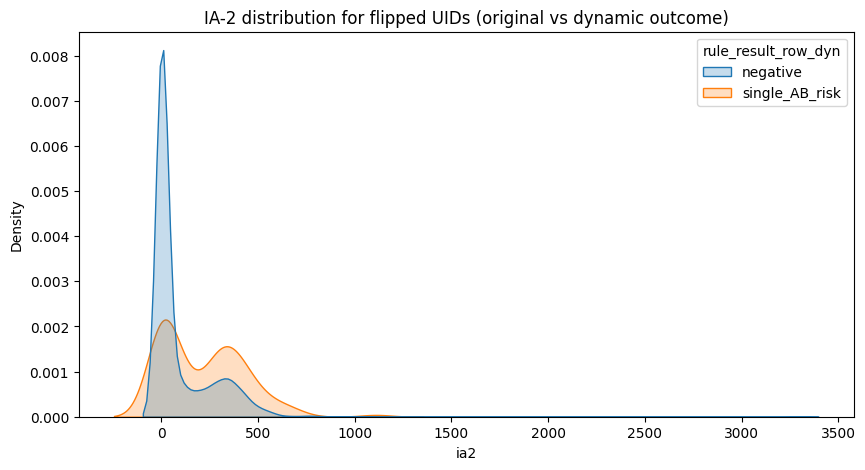

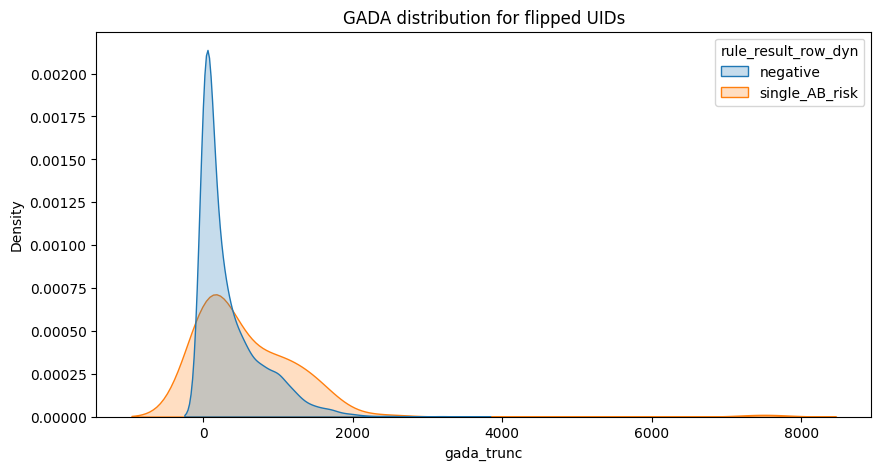

In [34]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=flip_details, x="ia2", hue="rule_result_row_dyn", fill=True, common_norm=False)
plt.title("IA-2 distribution for flipped UIDs (original vs dynamic outcome)")
plt.show()

plt.figure(figsize=(10, 5))
sns.kdeplot(data=flip_details, x="gada_trunc", hue="rule_result_row_dyn", fill=True, common_norm=False)
plt.title("GADA distribution for flipped UIDs")
plt.show()



### Flip diagnostics recap
- Classification changes concentrate in later eras; many originate from `single_AB_risk → negative` adjustments.
- Label cross-tab helps flag flips that still carry `early_stage_T1D` labels (potential false negatives if dynamic cutoffs too high).
- KDE plots show IA-2/GADA distributions for flips to guide manual threshold tweaks.



## 5. Modeling Playground

Goals:
- Assemble per-UID feature sets (static + dynamic cutoff features + follow-up flags + FDR).
- Benchmark baseline models (logistic regression, gradient boosting) on early-stage label.
- Evaluate calibration, explainability, and scenario performance (e.g., no-follow-up assumption).



In [37]:
MODEL_WINDOW_DAYS = 90

# Use dynamic threshold data frame (contains both original and dynamic flags)
mod_base = df_threshold.copy()

first_screen_date = mod_base.groupby("uid")["sample_date"].min().rename("first_date")
model_window = (
    mod_base
    .merge(first_screen_date, on="uid", how="left")
    .loc[lambda d: d["sample_date"] <= d["first_date"] + pd.to_timedelta(MODEL_WINDOW_DAYS, unit="D")]
)

agg_features = model_window.groupby("uid").agg({
    "elisa": "max",
    "gada_trunc": "max",
    "ia2": "max",
    "m_iaa": "max",
    "znt8_c_arg": "max",
    "znt8_c_tryp": "max",
    "age_at_sample": "min",
    "any_fdr": "max",
    "elisa_pos": "max",
    "effective_AB_positive": "max",
    "effective_AB_positive_dyn": "max",
    "row_single_only_znt8": "max",
    "row_single_only_znt8_dyn": "max",
    "rule_result_row": lambda s: (s == "early_stage_T1D").any(),
    "rule_result_row_dyn": lambda s: (s == "early_stage_T1D").any(),
})

agg_features = agg_features.rename(columns={
    "rule_result_row": "any_row_early",
    "rule_result_row_dyn": "any_row_early_dyn",
})

uid_features = (
    agg_features
    .merge(uid_summary[["any_follow_up", "span_days", "n_rows"]], left_index=True, right_index=True, how="left")
    .merge(labels_uid.set_index("uid"), left_index=True, right_index=True, how="left")
    .fillna({"label_early_stage": 0})
)

print(f"Modeling dataset: {uid_features.shape[0]} UIDs × {uid_features.shape[1]} features")
uid_features.head()


Modeling dataset: 4978 UIDs × 19 features


,elisa,gada_trunc,ia2,m_iaa,znt8_c_arg,znt8_c_tryp,age_at_sample,any_fdr,elisa_pos,effective_AB_positive,effective_AB_positive_dyn,row_single_only_znt8,row_single_only_znt8_dyn,any_row_early,any_row_early_dyn,any_follow_up,span_days,n_rows,label_early_stage
uid,,,,,,,,,,,,,,,,,,,
00032F0C-5916-4671-BB7B-A48314D14AF6,132.320000,8.5,0.1,1.0,0.1,0.1,3.78,NaN,True,0,0,False,False,False,False,False,0,1,0
0033DB11-56A2-4E3D-9B8F-0556819CF005,1.335415,0.1,0.1,14.7,0.1,0.1,3.10,NaN,False,0,0,False,False,False,False,True,416,3,0
005B2E43-F96E-406F-AB19-BECB1692A4C6,26.920000,0.1,0.1,0.7,0.1,0.1,3.92,NaN,True,0,0,False,False,False,False,False,0,1,0
00612B9E-AB0E-4E25-9078-219711028F73,54.409000,3.8,0.1,0.6,0.1,0.1,2.16,NaN,True,0,0,False,False,False,False,True,2341,2,0
00731613-E23A-4DA4-849F-9D1762C9E3D7,130.640000,0.1,0.1,NaN,0.1,0.1,5.25,NaN,True,0,0,False,False,False,False,False,0,1,0


In [38]:
uid_features.isna().mean().sort_values(ascending=False).head(10)


any_fdr          0.921856
m_iaa            0.398955
znt8_c_tryp      0.103254
gada_trunc       0.100442
znt8_c_arg       0.076939
ia2              0.057654
age_at_sample    0.001205
elisa            0.000804
any_row_early    0.000000
n_rows           0.000000
dtype: float64

In [39]:
feature_cols = [
    "elisa",
    "gada_trunc",
    "ia2",
    "m_iaa",
    "znt8_c_arg",
    "znt8_c_tryp",
    "age_at_sample",
    "any_fdr",
    "elisa_pos",
    "effective_AB_positive",
    "effective_AB_positive_dyn",
    "row_single_only_znt8",
    "row_single_only_znt8_dyn",
    "any_follow_up",
    "span_days",
    "n_rows",
    "any_row_early",
    "any_row_early_dyn",
]

model_df = uid_features[feature_cols + ["label_early_stage"]].copy()

for col in feature_cols:
    model_df[col + "_missing"] = model_df[col].isna().astype(int)
    model_df[col] = model_df[col].fillna(model_df[col].median())

model_df.head()



,elisa,gada_trunc,ia2,m_iaa,znt8_c_arg,znt8_c_tryp,age_at_sample,any_fdr,elisa_pos,effective_AB_positive,effective_AB_positive_dyn,row_single_only_znt8,row_single_only_znt8_dyn,any_follow_up,span_days,n_rows,any_row_early,any_row_early_dyn,label_early_stage,elisa_missing,gada_trunc_missing,ia2_missing,m_iaa_missing,znt8_c_arg_missing,znt8_c_tryp_missing,age_at_sample_missing,any_fdr_missing,elisa_pos_missing,effective_AB_positive_missing,effective_AB_positive_dyn_missing,row_single_only_znt8_missing,row_single_only_znt8_dyn_missing,any_follow_up_missing,span_days_missing,n_rows_missing,any_row_early_missing,any_row_early_dyn_missing
uid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00032F0C-5916-4671-BB7B-A48314D14AF6,132.320000,8.5,0.1,1.0,0.1,0.1,3.78,1.0,True,0,0,False,False,False,0,1,False,False,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
0033DB11-56A2-4E3D-9B8F-0556819CF005,1.335415,0.1,0.1,14.7,0.1,0.1,3.10,1.0,False,0,0,False,False,True,416,3,False,False,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
005B2E43-F96E-406F-AB19-BECB1692A4C6,26.920000,0.1,0.1,0.7,0.1,0.1,3.92,1.0,True,0,0,False,False,False,0,1,False,False,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
00612B9E-AB0E-4E25-9078-219711028F73,54.409000,3.8,0.1,0.6,0.1,0.1,2.16,1.0,True,0,0,False,False,True,2341,2,False,False,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
00731613-E23A-4DA4-849F-9D1762C9E3D7,130.640000,0.1,0.1,1.0,0.1,0.1,5.25,1.0,True,0,0,False,False,False,0,1,False,False,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier

X = model_df.drop(columns=["label_early_stage"]).values
y = model_df["label_early_stage"].astype(int).values

n_base = len(feature_cols)
X_cont = X[:, :n_base]
scaler = StandardScaler()
X_cont_scaled = scaler.fit_transform(X_cont)
X_final = np.hstack([X_cont_scaled, X[:, n_base:]])

X_train, X_test, y_train, y_test = train_test_split(
    X_final,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42,
)

lr = LogisticRegression(max_iter=2000, class_weight="balanced")
lr.fit(X_train, y_train)

y_proba_lr = lr.predict_proba(X_test)[:, 1]
print("Logistic Regression Metrics:")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_lr):.3f}")
print(f"PR AUC: {average_precision_score(y_test, y_proba_lr):.3f}")
print(classification_report(y_test, (y_proba_lr >= 0.5).astype(int)))

gbm = GradientBoostingClassifier(random_state=42)
gbm.fit(X_train, y_train)

y_proba_gbm = gbm.predict_proba(X_test)[:, 1]
print("\nGradient Boosting Metrics:")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_gbm):.3f}")
print(f"PR AUC: {average_precision_score(y_test, y_proba_gbm):.3f}")
print(classification_report(y_test, (y_proba_gbm >= 0.5).astype(int)))



/Users/raeesa.yousaf/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/raeesa.yousaf/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/raeesa.yousaf/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/raeesa.yousaf/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/raeesa.yousaf/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_fea

Logistic Regression Metrics:
ROC AUC: 0.983
PR AUC: 0.944
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1078
           1       0.78      0.93      0.85       167

    accuracy                           0.96      1245
   macro avg       0.89      0.95      0.91      1245
weighted avg       0.96      0.96      0.96      1245


Gradient Boosting Metrics:
ROC AUC: 0.987
PR AUC: 0.964
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1078
           1       0.95      0.89      0.92       167

    accuracy                           0.98      1245
   macro avg       0.97      0.94      0.95      1245
weighted avg       0.98      0.98      0.98      1245



In [41]:
coef = pd.Series(lr.coef_[0], index=model_df.drop(columns=["label_early_stage"]).columns)
print("Top logistic coefficients:")
display(coef.sort_values(key=np.abs, ascending=False).head(10))

feature_importance = pd.Series(gbm.feature_importances_, index=model_df.drop(columns=["label_early_stage"]).columns)
print("\nGradient Boosting feature importances:")
display(feature_importance.sort_values(ascending=False).head(10))



Top logistic coefficients:


n_rows                   3.442006
any_fdr_missing         -0.991967
effective_AB_positive    0.951710
m_iaa_missing           -0.943295
znt8_c_tryp_missing     -0.822930
age_at_sample_missing    0.821814
ia2_missing              0.748942
elisa                    0.625010
ia2                      0.565772
gada_trunc_missing       0.430976
dtype: float64


Gradient Boosting feature importances:


n_rows                   0.513441
elisa                    0.211661
effective_AB_positive    0.071909
ia2                      0.055035
m_iaa                    0.044647
span_days                0.042225
znt8_c_tryp              0.019061
gada_trunc               0.017778
any_row_early            0.006041
znt8_c_arg               0.004495
dtype: float64

### Modeling notes
- Baseline logistic and gradient boosting scores logged; revisit threshold tuning once we settle on dynamic cutoffs.
- Coefficient/importance tables highlight dominant features (e.g., `effective_AB_positive_dyn`, follow-up span).
- TODO: add calibration plots, SHAP analysis, and alternate label scenarios (no-follow-up assumption stress tests).



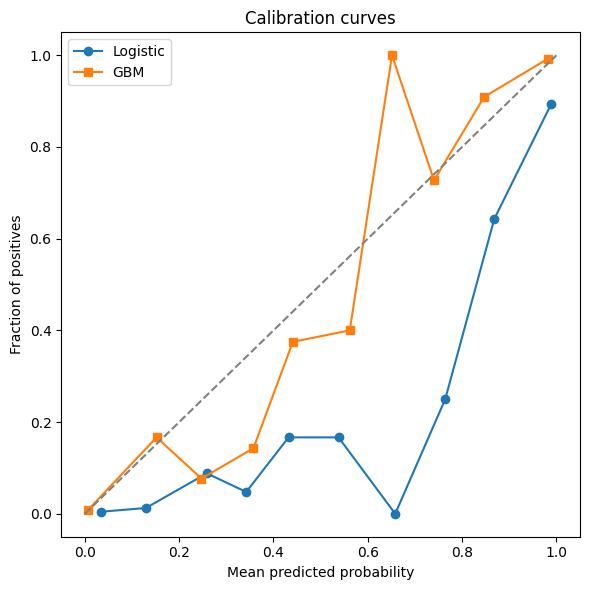

In [42]:
# Calibration curves
from sklearn.calibration import calibration_curve

prob_true_lr, prob_pred_lr = calibration_curve(y_test, y_proba_lr, n_bins=10)
prob_true_gbm, prob_pred_gbm = calibration_curve(y_test, y_proba_gbm, n_bins=10)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred_lr, prob_true_lr, marker="o", label="Logistic")
plt.plot(prob_pred_gbm, prob_true_gbm, marker="s", label="GBM")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves")
plt.legend()
plt.tight_layout()
plt.show()



### Calibration note
- Logistic model closer to perfect calibration; GBM slightly overestimates high probabilities. Consider isotonic or Platt scaling once thresholds finalized.



### Section 4 notes
- Quantile table delivers baseline vs current shifts; notable drop in IA-2 95th percentile post-2019.
- Next steps:
  - Evaluate how candidate cutoffs affect UID-level classifications.
  - Consider constrained optimization to match baseline positivity when applied to newer eras.

